In [1]:
import specsuite as ss
import matplotlib.pyplot as plt
import numpy as np

### Loading Data
Although you are able to load data using the same functions shown on other pages, there are some extra complications that GMOS-N presents during the loading process. Firstly, the FITS files produced by GMOS-N have twelve separate headers, each containing a portion of the complete readout. Secondly, the detector is comprised of three chips that are separated by a gap (~61 pixels in length). We need to represent these gaps using NaN values to prevent logical errors during the wavelength calibration, but we also need to mask those out before further analysis (since many of the processing functions were not made to handle NaN columns). Let's start by just loading in the relevant data.

collecting image array: 100%|██████████| 5/5 [00:00<00:00,  8.05it/s]


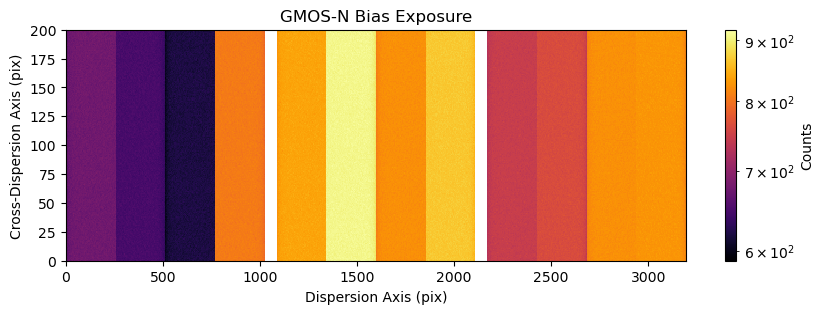

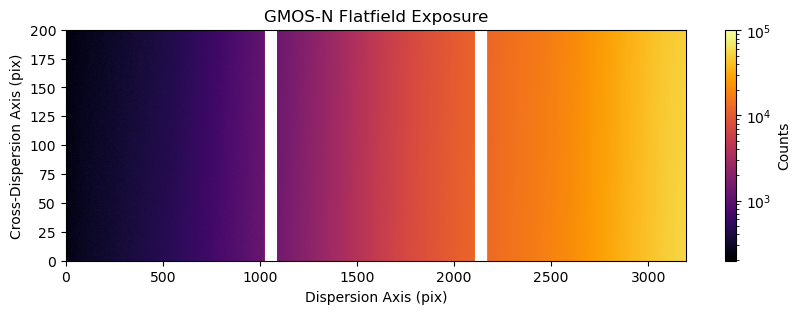

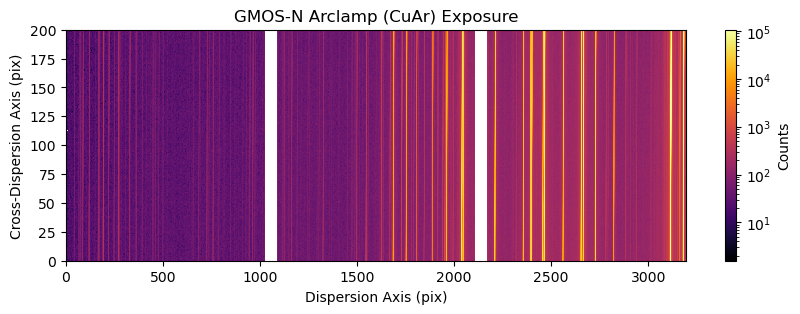

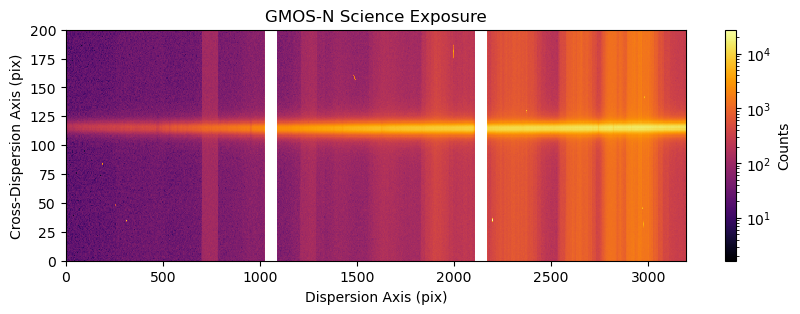

In [2]:
CAL_PATH = "../data/GMOS/calibrations"
DATA_PATH = "../data/GMOS/target"
DATA_REGION = (1750, 1950)
# DATA_REGION = (100, 300)

# Loads standard calibration images
full_bias = ss.average_matching_files(
    path = CAL_PATH,
    tag = "bias",
    instrument = "GMOS",
    crop_bds = DATA_REGION,
)
full_flat = ss.average_matching_files(
    path = CAL_PATH,
    tag = "flat", 
    instrument="GMOS",
    crop_bds = DATA_REGION,
) - full_bias
full_arc = ss.average_matching_files(
    path = "../data/GMOS/calibrations",
    tag = "CuAr",
    instrument = "GMOS",
    crop_bds = DATA_REGION,
) - full_bias

# Collects individual science exposures
full_science = ss.collect_images_array(
    path = DATA_PATH,
    tag = "toi3884",
    instrument = "GMOS",
    crop_bds = DATA_REGION,
    progress = True,
) - full_bias

ss.plot_image(full_bias, norm='log', title="GMOS-N Bias Exposure")
ss.plot_image(full_flat, norm='log', title="GMOS-N Flatfield Exposure")
ss.plot_image(full_arc, norm='log', title="GMOS-N Arclamp (CuAr) Exposure")
ss.plot_image(full_science[0], norm='log', title="GMOS-N Science Exposure")

We can see that these "chip gaps" appear as entirely white columns in our data. For data that looks like this, it is often simplest to split up each chip and process them individually. For simplicity, we will only process data from the rightmost chip.

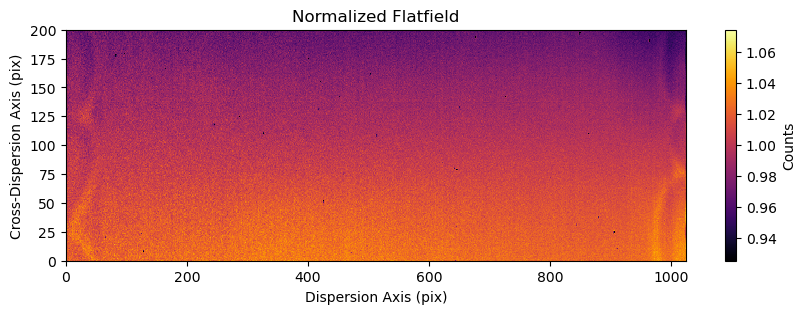

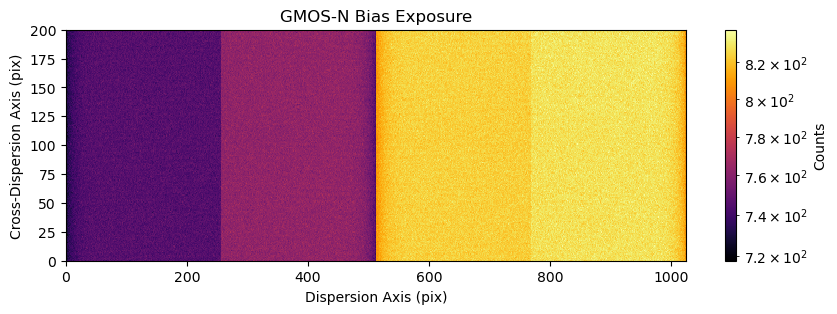

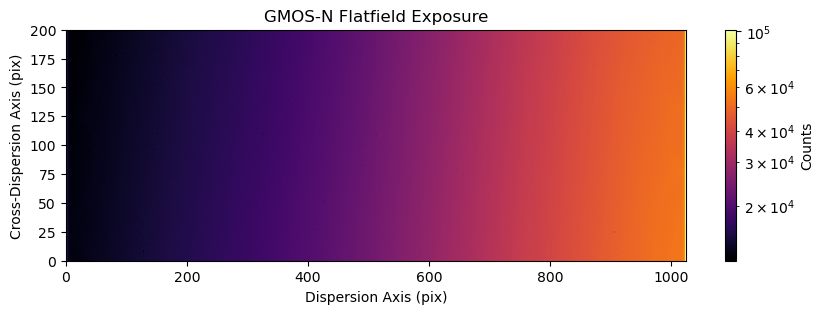

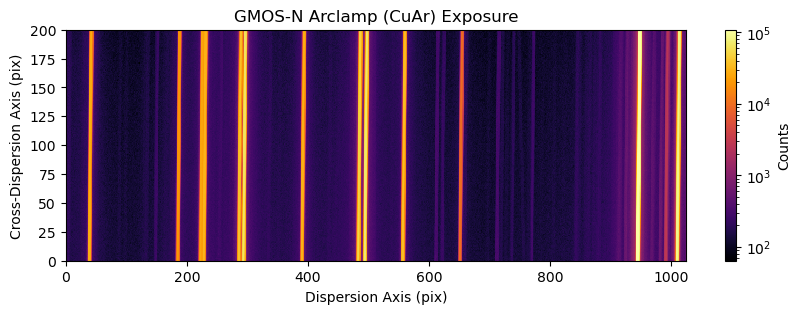

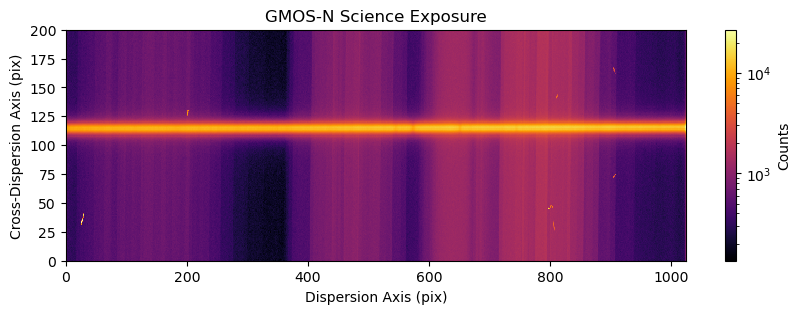

In [3]:
# Only keeps data from the rightmost chip
arc = ss.split_chips(full_arc)[0][2]
bias = ss.split_chips(full_bias)[0][2]
flat = ss.split_chips(full_flat)[0][2]
science = ss.split_chips(full_science)[:, 2]

science = ss.flatfield_correction(
    image = science,
    flat = flat,
    debug = True,
)

ss.plot_image(bias, norm='log', title="GMOS-N Bias Exposure")
ss.plot_image(flat, norm='log', title="GMOS-N Flatfield Exposure")
ss.plot_image(arc, norm='log', title="GMOS-N Arclamp (CuAr) Exposure")
ss.plot_image(science[0], norm='log', title="GMOS-N Science Exposure")

### Background Extraction
Next, we will generate a __warp model__ to use in a background extraction. Since GMOS-N is a fairly sensitive instrument, the threshold needed to identify line emissions in our arclamp exposure is much lower. A value of 6 works pretty well!

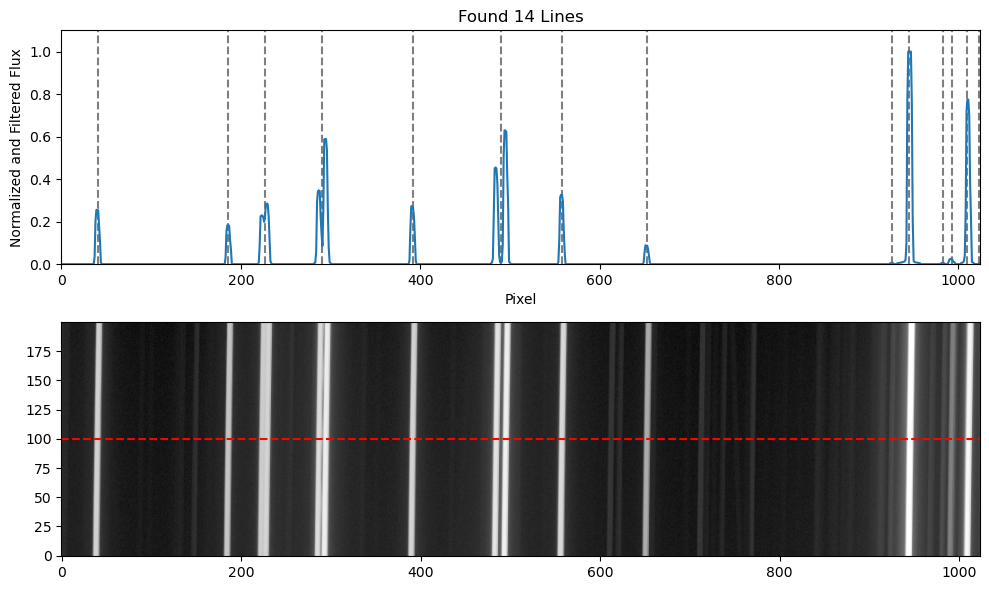

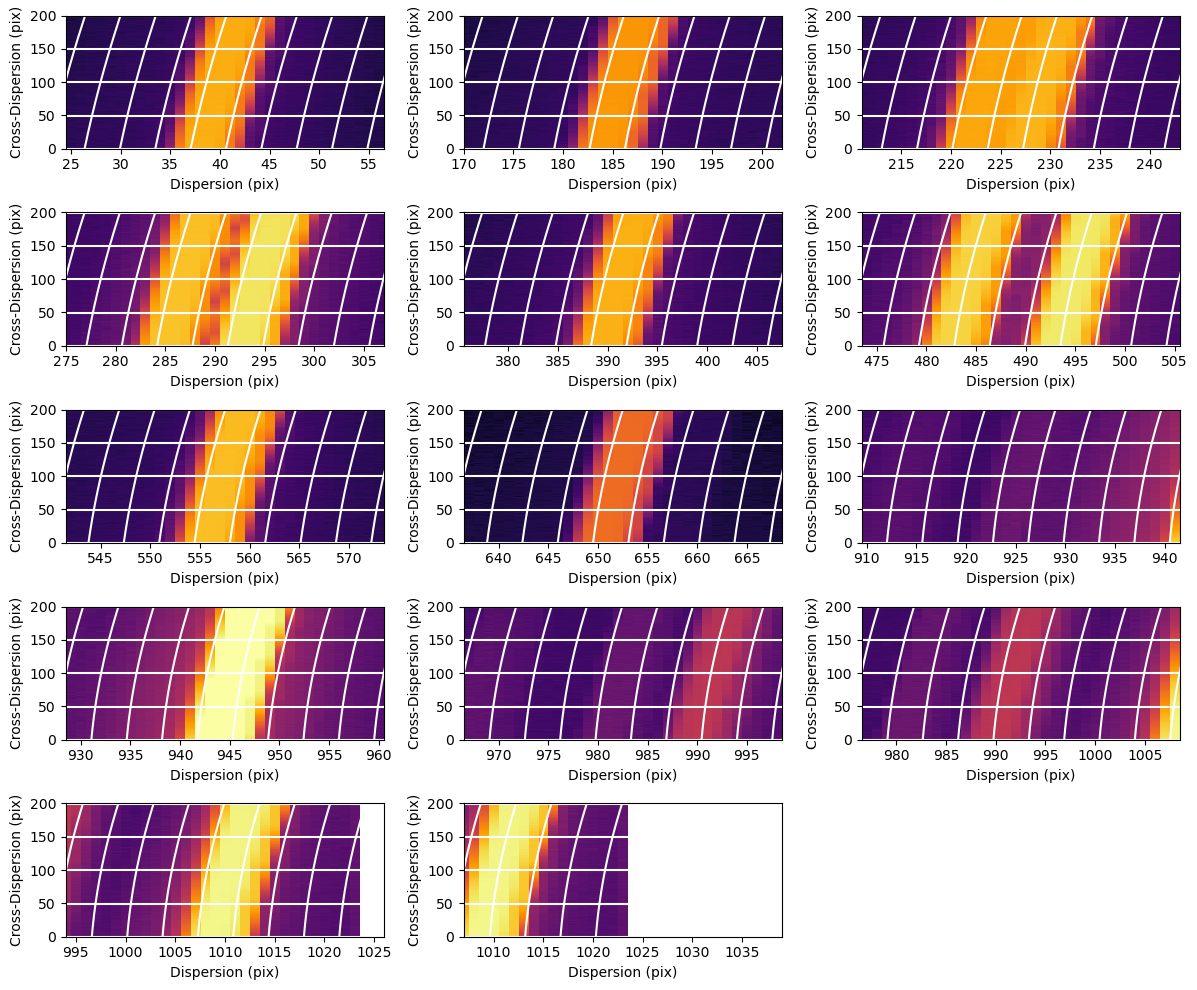

In [4]:
locs, _ = ss.find_cal_lines(
    image = arc,
    std_variation = 6,
    debug = True,
)

warp_model = ss.generate_warp_model(
    image = arc,
    guess = locs,
    debug = True,
)

We can see that the white grid seems to do a good job tracing out the shape of line emissions in our arclamp exposure, so our warp model is reasonably accurate! Let's go ahead and extract the background from our science exposures...

In [5]:
backgrounds = ss.extract_background(
    images = science,
    warp_model = warp_model,
    mask_region = (75, 150),
    update = True,
)

Extracting Background: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


It can be helpful to double-check that the extracted background looks reasonable!

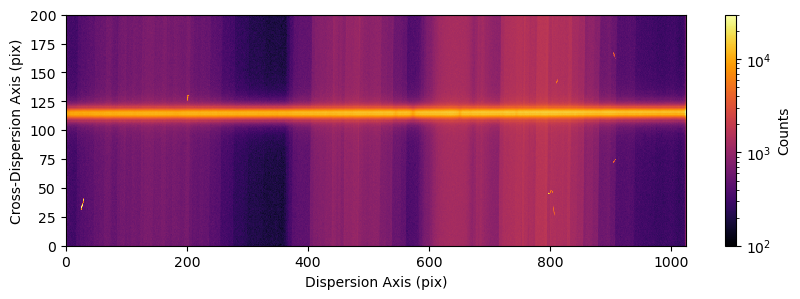

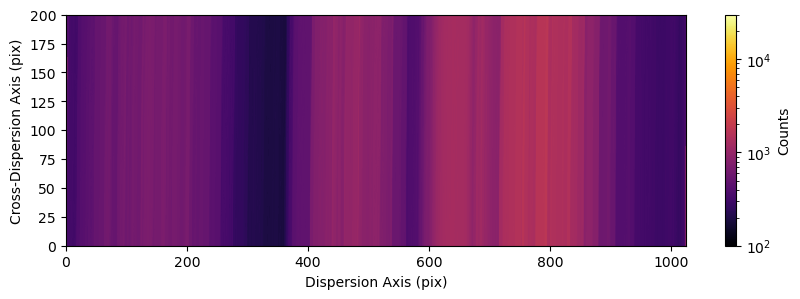

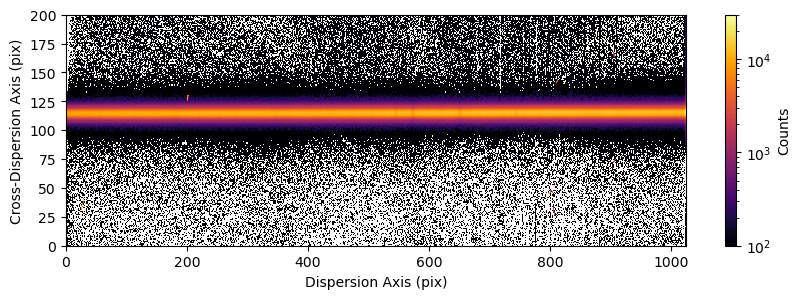

In [6]:
KWARGS = {"vmin": 1e2, "vmax": 3e4}

ss.plot_image(science[0], norm='log', **KWARGS)
ss.plot_image(backgrounds[0], norm='log', **KWARGS)
ss.plot_image(science[0] - backgrounds[0], norm='log', **KWARGS)

Since the region of the image that our target does not illuminate looks like random static, we can be reasonably certain that our background extraction is accurate!

### Flux Extraction

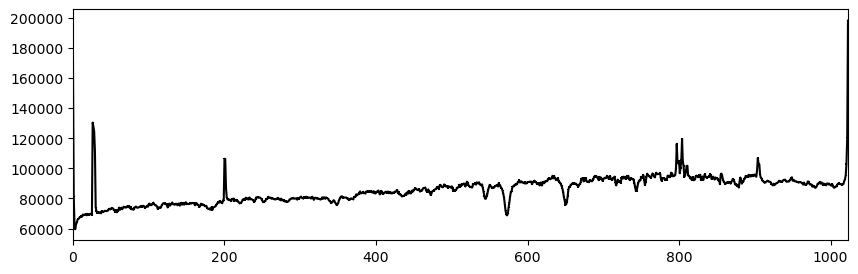

In [11]:
flux, error = ss.boxcar_extraction(
    science = science - backgrounds,
    backgrounds = backgrounds,
    RN = 10.0,
)

xs = np.array(range(len(flux[0])))
plt.errorbar(xs, flux[0], yerr=error[0], color='k')
plt.xlim(min(xs), max(xs))
plt.show()